# Project: Identify Customer Segments

## Done by: Mehdi Ghane
## Date: August 2020

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [237]:
# Load in the general demographics data.
azdias = pd.read_table('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_table('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
feat_info.head(5)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [77]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.info();
azdias.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [3]:
'''#Not work for object
# Identify missing or unknown data values and convert them to NaNs.
def fillnan (dataframe, feat_info):
    for i, col in enumerate(dataframe.columns):
        l = ast.literal_eval(feat_info['missing_or_unknown'][i])
        dataframe[col] = dataframe[col].apply(lambda x: np.nan if x in l else x)
'''

In [239]:
# Identify missing or unknown data values and convert them to NaNs.
def fillnan (dataframe, feat_info):
    lit = []
    for i, col in enumerate(dataframe.columns):
        l = []
        if feat_info['missing_or_unknown'][i][1:-1].split(',') !=['']:
            for item in feat_info['missing_or_unknown'][i].strip('[]').split(','):
                if item in ['X','XX']:
                    l.append(item) 
                else:  
                    l.append(int(item))
            dataframe[col] = dataframe[col].replace(l, np.nan)
        lit.append(l)

In [240]:
#conver missing values to np.nan
fillnan(azdias, feat_info)

In [242]:
print('Total number of missing values after conversion is {}'.format(azdias.isnull().sum().sum()))

Total number of missing values after conversion is 8373929


In [243]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               205378 non-null  float64
 1   ALTERSKATEGORIE_GROB   888340 non-null  float64
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            498903 non-null  float64
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             780025 non-nu

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [244]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
sumnull = pd.DataFrame(azdias.isnull().sum()).reset_index()
sumnull.columns = ['attribute', '#null']
sumnull = sumnull.sort_values(by='#null', ascending=False)
sumnull = sumnull.merge(feat_info, on='attribute').drop('missing_or_unknown', axis=1)
sumnull['%null'] = round(sumnull['#null']*100/azdias.shape[0],2)
sumnull.head(10)

,attribute,#null,information_level,type,%null
0,TITEL_KZ,889061,person,categorical,99.76
1,AGER_TYP,685843,person,categorical,76.96
2,KK_KUNDENTYP,584612,household,categorical,65.60
3,KBA05_BAUMAX,476524,microcell_rr3,mixed,53.47
4,GEBURTSJAHR,392318,person,numeric,44.02
5,ALTER_HH,310267,household,interval,34.81
6,KKK,158064,region_rr1,ordinal,17.74
7,REGIOTYP,158064,region_rr1,ordinal,17.74
8,W_KEIT_KIND_HH,147988,household,ordinal,16.61
9,KBA05_ANTG1,133324,microcell_rr3,ordinal,14.96


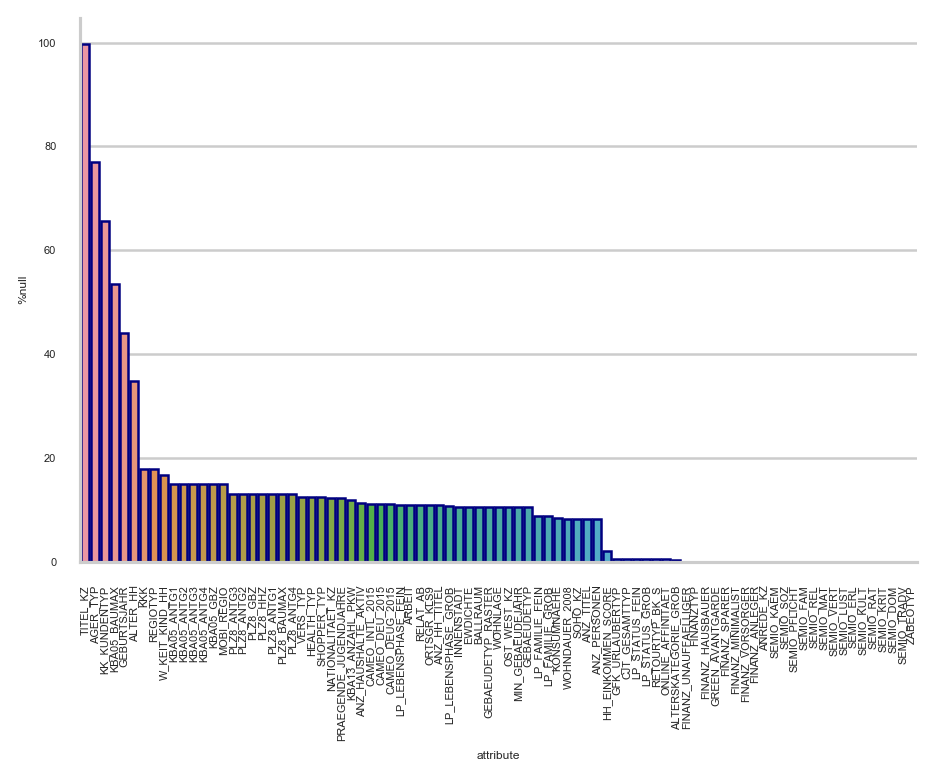

In [245]:
sns.set(style="whitegrid",palette = 'pastel', font_scale=0.4)
fig1,axes=plt.subplots(nrows=1,ncols=1,dpi=180)
sns.barplot(y= '%null', 
              x= 'attribute' ,
              data=sumnull , 
              edgecolor='navy')
sns.despine()
plt.xticks(rotation = 90);

In [246]:
# Investigate patterns in the amount of missing data in each column.
sumnull.groupby('information_level').sum().sort_values(by='#null', ascending=False)

,#null,%null
information_level,,
person,2965727,332.76
household,1281712,143.83
microcell_rr3,1143144,128.27
macrocell_plz8,921405,103.36
building,643180,72.16
region_rr1,547461,61.43
microcell_rr4,298056,33.45
community,292024,32.77
postcode,281220,31.56


In [247]:
# Investigate patterns in the amount of missing data in each column.
sumnull.groupby('type').sum().sort_values(by='#null', ascending=False)

,#null,%null
type,,
categorical,3123722,350.50
ordinal,2919150,327.54
mixed,1085907,121.84
numeric,934883,104.90
interval,310267,34.81


In [251]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
Threshold = 20
azdias.drop(sumnull[sumnull['%null']>Threshold]['attribute'].tolist(), axis=1, inplace=True)

#### Discussion 1.1.2: Assess Missing Data in Each Column

Person and household level of data have the most missing values. Based on data type, ordinal and categorical data have the most null values. There are six columns of data each one has more than 20% of missing values which made them a good candidate to entirely being removed from dataset. Those columns are 'Best-ager typology' , 'Consumer pattern over past 12 months' , 'Year of birth', 'Most common building type within the microcell', and 'Academic title'.  

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [252]:
# How much data is missing in each row of the dataset?
rownull = pd.DataFrame(round(azdias.isnull().sum(axis=1)*100/azdias.shape[1],2))
rownull.columns = ['%null']
rownull

,%null
0,54.43
1,0.00
2,0.00
3,8.86
4,0.00
...,...
891216,3.80
891217,5.06
891218,6.33
891219,0.00


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020F834CBE08>]],
      dtype=object)

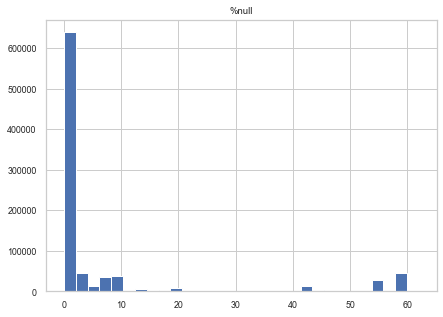

In [266]:
sns.set(style="whitegrid",palette = 'deep', font_scale=0.8)
rownull.hist(figsize=(7,5), bins=30)

In [263]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
threshold = 15
indeces = rownull.loc[rownull['%null']<threshold].index
good_subset = azdias.loc[indeces]
bad_subset = azdias.drop(indeces, axis=0)

In [264]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
cols_to_compare = sumnull[sumnull['%null']==0]['attribute'].values.tolist() # select columns with zero null values to be used for comparison

def compare(good_subset, bad_subset, column_number):
    sns.set(style="whitegrid",palette = 'pastel', font_scale=0.6)
    fig,ax=plt.subplots(nrows=1,ncols=2,dpi=100 )
    plt.subplots_adjust(wspace = .3 ,hspace=.6)
    sns.countplot(good_subset[cols_to_compare[column_number]], ax = ax[0])
    sns.countplot(bad_subset[cols_to_compare[column_number]], ax = ax[1])
    plt.suptitle('Good data versus bad data')

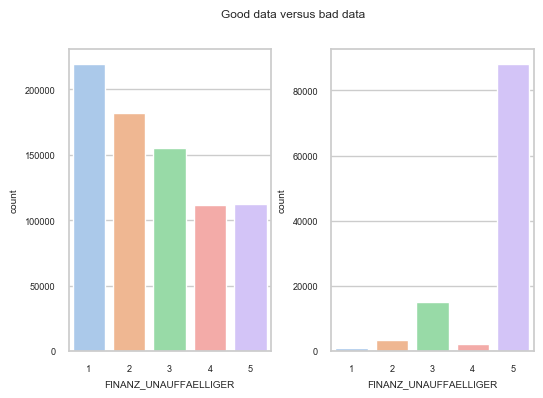

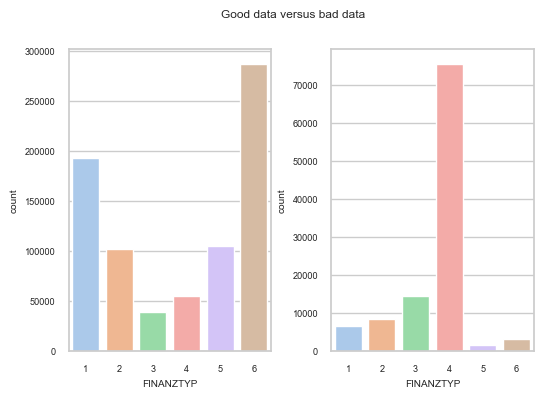

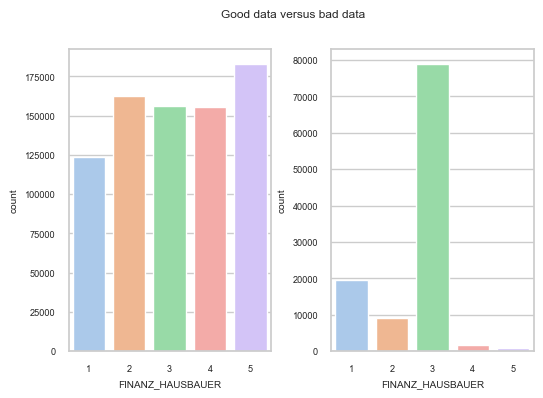

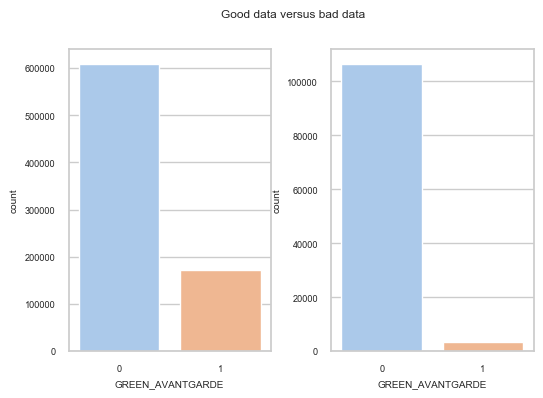

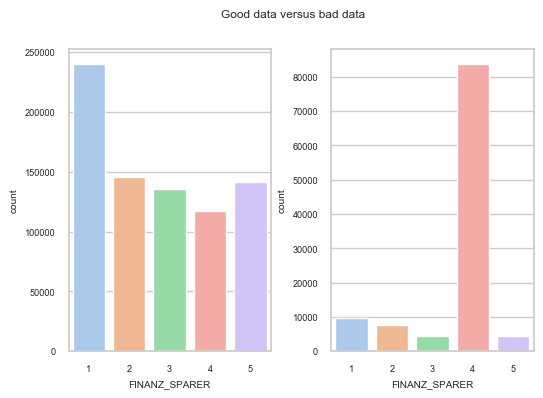

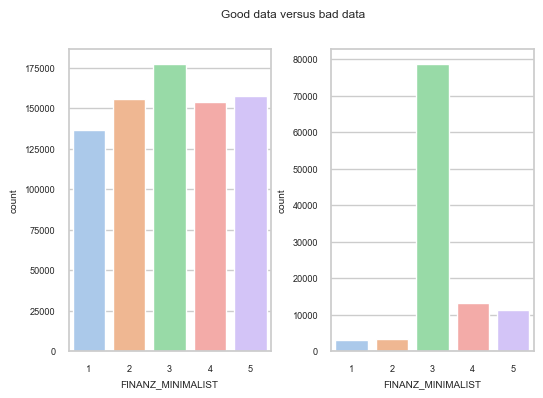

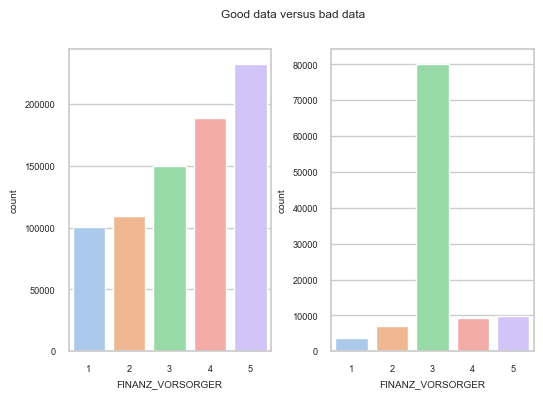

In [265]:
for i in range(0,7):
    compare(good_subset, bad_subset, i)

#### Discussion 1.1.3: Assess Missing Data in Each Row
I selected 15% as threshold value to seperate data in regards to missing values. Data with lots of missing values are qualitatively different from data with few or no missing values. The difference is obvious by exploring 7 columns with zero null value. It means discarding the bad dataset with lots of missing values in their rows is not recommended as it causes some aspect of variability in the data to be lost. However, I will continue my analysis using good dataset as per instruction.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [267]:
# How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

In [272]:
# Exclude those attributes (features) with many null values from feat_info
feat_info = feat_info[feat_info['attribute'].isin([feat for feat in feat_info['attribute'] \
               if feat not in sumnull[sumnull['%null']>Threshold]['attribute'].tolist()])]

In [273]:
# extract categorical features
categorical_feat = feat_info[feat_info['type']=='categorical']['attribute'].values.tolist()

In [274]:
# select all categorical and mixed features
good_subset[categorical_feat].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 781280 entries, 1 to 891220
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ANREDE_KZ         781280 non-null  int64  
 1   CJT_GESAMTTYP     777401 non-null  float64
 2   FINANZTYP         781280 non-null  int64  
 3   GFK_URLAUBERTYP   777401 non-null  float64
 4   GREEN_AVANTGARDE  781280 non-null  int64  
 5   LP_FAMILIE_FEIN   752071 non-null  float64
 6   LP_FAMILIE_GROB   752071 non-null  float64
 7   LP_STATUS_FEIN    777401 non-null  float64
 8   LP_STATUS_GROB    777401 non-null  float64
 9   NATIONALITAET_KZ  749164 non-null  float64
 10  SHOPPER_TYP       746520 non-null  float64
 11  SOHO_KZ           781280 non-null  float64
 12  VERS_TYP          746520 non-null  float64
 13  ZABEOTYP          781280 non-null  int64  
 14  GEBAEUDETYP       781280 non-null  float64
 15  OST_WEST_KZ       781280 non-null  object 
 16  CAMEO_DEUG_2015   77

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [275]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
good_subset[categorical_feat].nunique(),\
good_subset[categorical_feat]['OST_WEST_KZ'].value_counts()

(ANREDE_KZ            2
 CJT_GESAMTTYP        6
 FINANZTYP            6
 GFK_URLAUBERTYP     12
 GREEN_AVANTGARDE     2
 LP_FAMILIE_FEIN     11
 LP_FAMILIE_GROB      5
 LP_STATUS_FEIN      10
 LP_STATUS_GROB       5
 NATIONALITAET_KZ     3
 SHOPPER_TYP          4
 SOHO_KZ              2
 VERS_TYP             2
 ZABEOTYP             6
 GEBAEUDETYP          7
 OST_WEST_KZ          2
 CAMEO_DEUG_2015      9
 CAMEO_DEU_2015      44
 dtype: int64,
 W    615657
 O    165623
 Name: OST_WEST_KZ, dtype: int64)

In [276]:
# Re-encode categorical variable(s) to be kept in the analysis.
good_subset['OST_WEST_KZ'] = good_subset['OST_WEST_KZ'].map({'W':0,'O':1})
good_subset.drop('CAMEO_DEU_2015',axis=1, inplace=True)

In [277]:
categorical_feat.pop()

'CAMEO_DEU_2015'

In [278]:
s = good_subset[categorical_feat].nunique()
reencode_cols = s[s>2].index.tolist()

In [279]:
good_subset[reencode_cols]

,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,ZABEOTYP,GEBAEUDETYP,CAMEO_DEUG_2015
1,5.0,1,10.0,5.0,3.0,2.0,1.0,1.0,3.0,5,8.0,8
2,3.0,1,10.0,1.0,1.0,3.0,2.0,1.0,2.0,5,1.0,4
3,2.0,6,1.0,NaN,NaN,9.0,4.0,1.0,1.0,3,1.0,2
4,5.0,5,5.0,10.0,5.0,3.0,2.0,1.0,2.0,4,1.0,6
5,2.0,2,1.0,1.0,1.0,4.0,2.0,1.0,0.0,4,1.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...
891216,5.0,1,12.0,1.0,1.0,2.0,1.0,1.0,3.0,4,8.0,7
891217,4.0,6,1.0,1.0,1.0,1.0,1.0,NaN,NaN,6,8.0,9
891218,4.0,1,10.0,NaN,NaN,4.0,2.0,1.0,2.0,4,8.0,4
891219,3.0,1,9.0,9.0,5.0,2.0,1.0,1.0,0.0,5,8.0,9


In [297]:
df = good_subset.merge(pd.get_dummies(good_subset[reencode_cols].astype(str),drop_first=True),right_index=True, left_index=True)\
        .drop(reencode_cols,axis=1)

In [298]:
df.shape

(781280, 147)

#### Discussion 1.2.1: Re-Encode Categorical Features

'OST_WEST_KZ' is an object variable which is converted to a numeric binary.'CAMEO_DEU_2015' is removed because it is redundant. All other variables with more than 2 unique value are candiates for OneHotEncoding. Dummy variables are defined based on those candidates and original variables are removed from database. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [299]:
# Extract Mixed Features
mixed_feat = feat_info[feat_info['type']=='mixed']['attribute'].values.tolist()
mixed_feat

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [300]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
decade = {1.0:40, 2.0:40, 3.0:50, 4.0:50, 5.0:60, 6.0:60, 7.0:60,
         8.0:70, 9.0:70, 10.0:80, 11.0:80, 12.0:80, 13.0:80, 14.0:90, 15.0:90}
# Mainstream:1, Avantgrade:2
movement = {1.0:1, 2.0:2, 3.0:1, 4.0:2, 5.0:1, 6.0:2, 7.0:2,
         8.0:1, 9.0:2, 10.0:1, 11.0:2, 12.0:1, 13.0:2, 14.0:1, 15.0:2}
df['decade'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade)
df['movement'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement)

# drop 'PRAEGENDE_JUGENDJAHRE' from df
df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

In [301]:
# remove na form 'CAMEO_INTL_2015' column
df.dropna(subset=['CAMEO_INTL_2015'], inplace=True)

In [302]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
df['wealth'] = [int(x)//10 for x in df['CAMEO_INTL_2015']]
df['life_stage'] = [int(x)%10 for x in df['CAMEO_INTL_2015']]

# drop the original 'CAMEO_INTL_2015' from df
df.drop('CAMEO_INTL_2015', axis=1, inplace=True)

In [303]:
# drop these two features to avoid redundancy
df.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB'], axis=1, inplace=True)

In [304]:
df.shape

(777173, 147)

#### Discussion 1.2.2: Engineer Mixed-Type Features

'LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB' have been removed because of overlap with 'CAMEO_INTL_2015'.
'CAMEO_INTL_2015' and 'PRAEGENDE_JUGENDJAHRE' are engineered to extract more specific features as per instruction.
Rest of mixed features are kept as they are believing they are good features to keep. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [305]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
df.describe().transpose() 

,count,mean,std,min,25%,50%,75%,max
ALTERSKATEGORIE_GROB,774538.0,2.797422,1.019072,1.0,2.0,3.0,4.0,4.0
ANREDE_KZ,777173.0,1.521432,0.499541,1.0,1.0,2.0,2.0,2.0
FINANZ_MINIMALIST,777173.0,3.048916,1.377873,1.0,2.0,3.0,4.0,5.0
FINANZ_SPARER,777173.0,2.712440,1.487141,1.0,1.0,3.0,4.0,5.0
FINANZ_VORSORGER,777173.0,3.439921,1.376472,1.0,2.0,4.0,5.0,5.0
...,...,...,...,...,...,...,...,...
CAMEO_DEUG_2015_nan,777173.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
decade,750765.0,73.238390,14.589726,40.0,60.0,70.0,90.0,90.0
movement,750765.0,1.227970,0.419524,1.0,1.0,1.0,1.0,2.0
wealth,777173.0,3.274059,1.465472,1.0,2.0,4.0,5.0,5.0


In [306]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 777173 entries, 1 to 891220
Data columns (total 147 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ALTERSKATEGORIE_GROB   float64
 1   ANREDE_KZ              int64  
 2   FINANZ_MINIMALIST      int64  
 3   FINANZ_SPARER          int64  
 4   FINANZ_VORSORGER       int64  
 5   FINANZ_ANLEGER         int64  
 6   FINANZ_UNAUFFAELLIGER  int64  
 7   FINANZ_HAUSBAUER       int64  
 8   GREEN_AVANTGARDE       int64  
 9   HEALTH_TYP             float64
 10  RETOURTYP_BK_S         float64
 11  SEMIO_SOZ              int64  
 12  SEMIO_FAM              int64  
 13  SEMIO_REL              int64  
 14  SEMIO_MAT              int64  
 15  SEMIO_VERT             int64  
 16  SEMIO_LUST             int64  
 17  SEMIO_ERL              int64  
 18  SEMIO_KULT             int64  
 19  SEMIO_RAT              int64  
 20  SEMIO_KRIT             int64  
 21  SEMIO_DOM              int64  
 22  SEMIO_KAEM         

In [307]:
# imputation on nan values
df.fillna(df.median(), inplace=True)

In [308]:
# change types to reduce memory and create a dataframe gp stands General Population
d = dict.fromkeys(df.select_dtypes(np.float64).columns, np.int32)
gp = df.astype(d)
gp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 777173 entries, 1 to 891220
Columns: 147 entries, ALTERSKATEGORIE_GROB to life_stage
dtypes: int32(41), int64(25), uint8(81)
memory usage: 335.7 MB


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [333]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    ## Copy the dataframe
    df1 = df.copy()
    
    ##1. convert missing value codes into NaNs, ...
    fillnan(df1, feat_info)
    
    ##2. remove selected columns and rows, ...    
    # Perform an assessment of how much missing data there is in each column of the dataset.
    sumnull = pd.DataFrame(df1.isnull().sum()).reset_index()
    sumnull.columns = ['attribute', '#null']
    sumnull = sumnull.sort_values(by='#null', ascending=False)
    sumnull = sumnull.merge(feat_info, on='attribute').drop('missing_or_unknown', axis=1)
    sumnull['%null'] = round(sumnull['#null']*100/df1.shape[0],2)
    # Remove columns with more than 35% missing data
    drop_cols = sumnull[sumnull['%null']>35]['attribute'].tolist()
    df1.drop(drop_cols, axis=1, inplace=True)
    # Perform an assessment of how much missing data there is in each row of the dataset.
    rownull = pd.DataFrame(round(df1.isnull().sum(axis=1)*100/df1.shape[1],2))
    rownull.columns = ['%null']
    # Remove rows with more than 15% missing data
    indeces = rownull.loc[rownull['%null']<15].index
    good_subset = df1.loc[indeces]
    
    ##3. select, re-encode, and engineer column values.
    # Exclude those attributes (features) with many null values from feat_info
    feat_info = feat_info[feat_info['attribute'].isin([feat for feat in feat_info['attribute'] if feat not in drop_cols])]
    # extract categorical features
    categorical_feat = feat_info[feat_info['type']=='categorical']['attribute'].values.tolist()
    # Re-encode categorical variable(s) to be kept in the analysis.
    good_subset['OST_WEST_KZ'] = good_subset['OST_WEST_KZ'].map({'W':0,'O':1})
    good_subset.drop('CAMEO_DEU_2015',axis=1, inplace=True)
    categorical_feat.pop()
    s = good_subset[categorical_feat].nunique()
    reencode_cols = s[s>2].index.tolist()
    df1 =good_subset.merge(pd.get_dummies(good_subset[reencode_cols].astype(str),drop_first=True),right_index=True, left_index=True).drop(reencode_cols,axis=1)
    # Mixed features
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    decade = {1.0:40, 2.0:40, 3.0:50, 4.0:50, 5.0:60, 6.0:60, 7.0:60,
              8.0:70, 9.0:70, 10.0:80, 11.0:80, 12.0:80, 13.0:80, 14.0:90, 15.0:90}
    # Mainstream:1, Avantgrade:2
    movement = {1.0:1, 2.0:2, 3.0:1, 4.0:2, 5.0:1, 6.0:2, 7.0:2,
                8.0:1, 9.0:2, 10.0:1, 11.0:2, 12.0:1, 13.0:2, 14.0:1, 15.0:2}
    df1['decade'] = df1['PRAEGENDE_JUGENDJAHRE'].map(decade)
    df1['movement'] = df1['PRAEGENDE_JUGENDJAHRE'].map(movement)
    # drop 'PRAEGENDE_JUGENDJAHRE' from df
    df1.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    # remove na form 'CAMEO_INTL_2015' column
    df1.dropna(subset=['CAMEO_INTL_2015'], inplace=True)
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    df1['wealth'] = [int(x)//10 for x in df1['CAMEO_INTL_2015']]
    df1['life_stage'] = [int(x)%10 for x in df1['CAMEO_INTL_2015']]
    # drop the original 'CAMEO_INTL_2015' from df
    df1.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    # drop these two features to avoid redundancy
    df1.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB'], axis=1, inplace=True)
    #Imputation to replace null values.
    df1.fillna(df1.median(), inplace=True)
    # change types to reduce memory and create a dataframe gp stands General Population
    d = dict.fromkeys(df1.select_dtypes(np.float64).columns, np.int32)
    df1 = df1.astype(d)
    
    ##4. Return the cleaned dataframe.
    return df1, good_subset
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [310]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
sum(gp.isnull().sum()>0)

0

In [311]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scaled = StandardScaler()
scaled_gp = pd.DataFrame(index= gp.index, data = scaled.fit_transform(gp), columns=gp.columns)

In [312]:
scaled_gp.head(3)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_nan,decade,movement,wealth,life_stage
1,-1.767339,0.958016,-1.487014,1.538228,-1.046096,1.467736,0.978703,1.326081,-0.531431,1.089299,...,-0.2718,-0.394019,-0.33133,2.196432,-0.400374,0.0,1.175586,-0.531431,1.177738,-1.257358
2,0.198436,0.958016,-1.487014,0.865796,-1.772592,-0.568526,0.261301,1.326081,1.881711,1.089299,...,-0.2718,-0.394019,-0.33133,-0.455284,-0.400374,0.0,1.175586,1.881711,-0.869385,0.758992
3,1.181323,0.958016,0.690256,-0.479067,1.133390,-0.568526,-1.173504,-0.818278,-0.531431,-0.263334,...,-0.2718,-0.394019,-0.33133,-0.455284,-0.400374,0.0,-0.217978,-0.531431,-1.551760,-0.585242


### Discussion 2.1: Apply Feature Scaling

Imputation has been used to replace null values with median value of each column. Then Standard scaling is applied to the data set. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [313]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
def do_pca(df, n_components = None):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.
    
    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform
           
    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    # scaling of dataset
    scaled = StandardScaler()
    scaled_fitted = scaled.fit(df)
    X = scaled_fitted.transform(df)
    
    # fitting PCA
    pca = PCA(n_components)
    pca_fitted = pca.fit(X)
    X_pca = pca_fitted.transform(X)
    return scaled_fitted, pca, pca_fitted, X_pca

# Run PCA
_, pca, _ , X_pca = do_pca(gp)

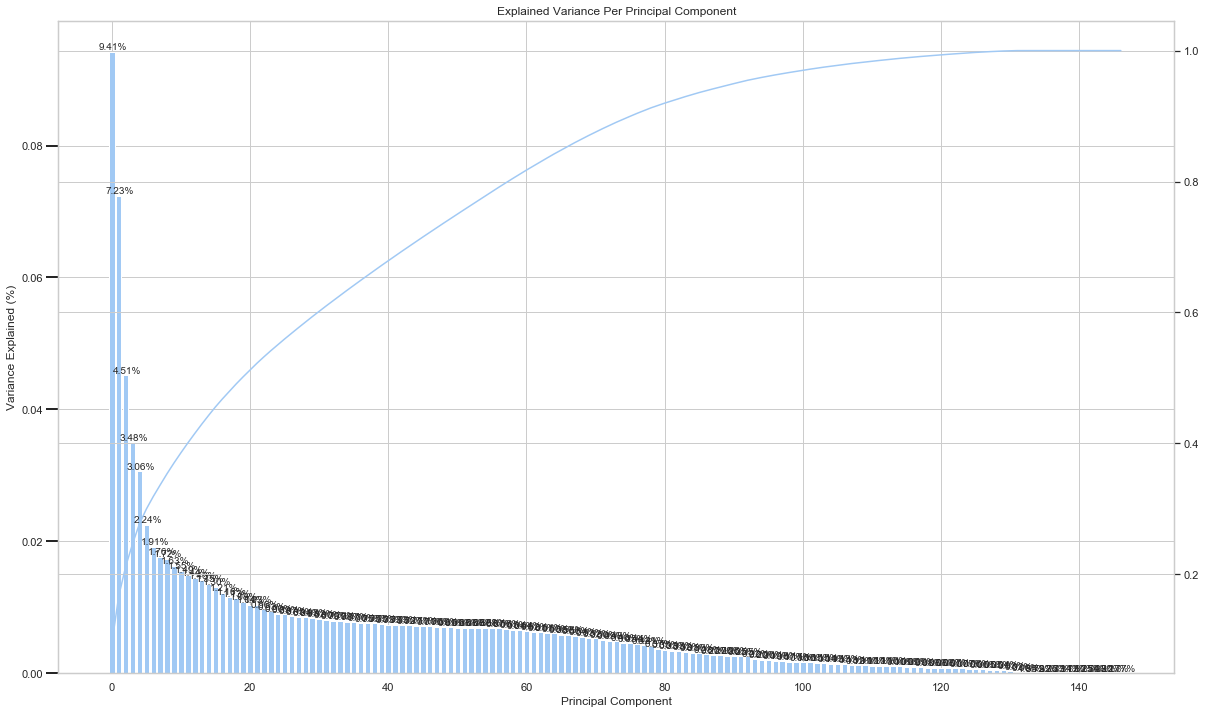

In [314]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    sns.set(style="whitegrid",palette = 'pastel', font_scale=1)
    plt.figure(figsize=(20, 12))
    ax = plt.subplot()
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax2 = ax.twinx()
    ax2.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=10,
                   horizontalalignment='right', verticalalignment='top')
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

scree_plot(pca)

In [315]:
# Re-apply PCA to the data while selecting for number of components to retain.
scaled_fitted, pca, pca_fitted, X_pca = do_pca(gp,20)  

### Discussion 2.2: Perform Dimensionality Reduction

With 20 components we maintain almost 50% of variability in the dataset. Since we donot have a big data (row numbers are less than 1 million), keeping more features does not adversely affect the processing speed yet the quality of analysis will remained intact. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [316]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def feature_sort(df, pca, ith_component):
    features = {}
    A = gp.columns.values
    B = pca.components_[ith_component]
    for a, b in zip(A, B):
        features[a] = b

    # sort the dictionary
    sorted_dict = sorted(zip(features.values(),features.keys()), reverse=True)
    return sorted_dict

feature_sort(gp, pca, 0)

[(0.1972706786917988, 'PLZ8_ANTG3'),
 (0.19175786042752413, 'PLZ8_ANTG4'),
 (0.18778219227837661, 'wealth'),
 (0.18690815270130257, 'PLZ8_BAUMAX'),
 (0.1861120428671347, 'HH_EINKOMMEN_SCORE'),
 (0.1699323707314911, 'ORTSGR_KLS9'),
 (0.16794673436961827, 'EWDICHTE'),
 (0.15102734671411258, 'FINANZ_HAUSBAUER'),
 (0.1348936651180459, 'KBA05_ANTG4'),
 (0.13442889451489318, 'PLZ8_ANTG2'),
 (0.13190729957496966, 'FINANZ_SPARER'),
 (0.12589865970487643, 'LP_STATUS_FEIN_2.0'),
 (0.12288570913747258, 'ARBEIT'),
 (0.12185178114585273, 'KBA05_ANTG3'),
 (0.11978105795587274, 'ANZ_HAUSHALTE_AKTIV'),
 (0.11663600739802427, 'CAMEO_DEUG_2015_9'),
 (0.11562000292111171, 'RELAT_AB'),
 (0.09993941151194258, 'SEMIO_PFLICHT'),
 (0.0979029202642133, 'SEMIO_REL'),
 (0.09377359094716795, 'CAMEO_DEUG_2015_8'),
 (0.08878608801371182, 'decade'),
 (0.08265600001713658, 'ZABEOTYP_5'),
 (0.08222174827209042, 'SEMIO_RAT'),
 (0.07534285604910942, 'SEMIO_TRADV'),
 (0.07034063611641564, 'GEBAEUDETYP_3.0'),
 (0.06768290

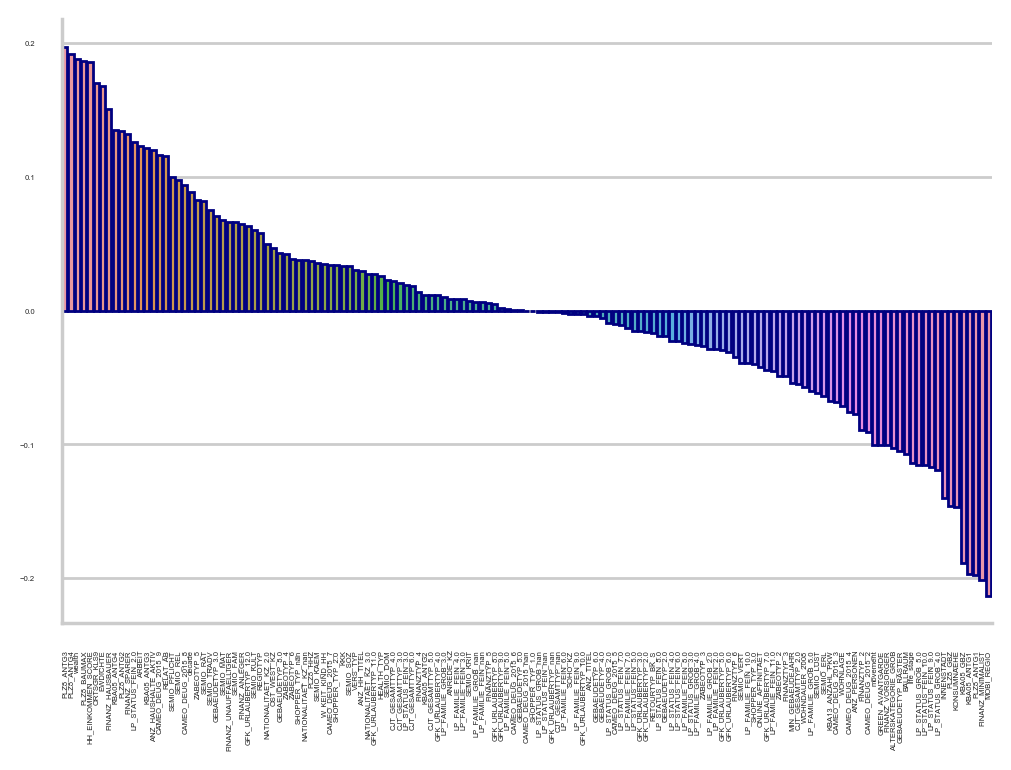

In [317]:
# define  function to plot features together with their weight in the ith component
def plot_features (sorted_dict):
    values = [x[0] for x in sorted_dict]
    features = [x[1] for x in sorted_dict]
    sns.set(style="whitegrid",palette = 'pastel', font_scale=0.25)
    fig1,axes=plt.subplots(nrows=1,ncols=1,dpi=200)
    sns.barplot(y= values, 
                  x= features , 
                  edgecolor='navy')
    sns.despine()
    plt.xticks(rotation = 90);
    
plot_features(feature_sort(gp, pca, 0))

([(0.23236888185660437, 'ALTERSKATEGORIE_GROB'),
  (0.2197560504570586, 'FINANZ_VORSORGER'),
  (0.20226441810260137, 'ZABEOTYP_3'),
  (0.1830583107081273, 'SEMIO_ERL'),
  (0.16518588890231137, 'SEMIO_LUST'),
  (0.15839582451926376, 'RETOURTYP_BK_S'),
  (0.1278105888554922, 'W_KEIT_KIND_HH'),
  (0.10935828541815314, 'CJT_GESAMTTYP_2.0'),
  (0.10179111143150052, 'FINANZTYP_5'),
  (0.10170006445738476, 'FINANZ_HAUSBAUER'),
  (0.08810772979273308, 'FINANZTYP_2'),
  (0.08611856731660253, 'PLZ8_ANTG3'),
  (0.08439402764678564, 'EWDICHTE'),
  (0.08337757196036147, 'ORTSGR_KLS9'),
  (0.08179170293549792, 'PLZ8_ANTG4'),
  (0.07704705218477453, 'SHOPPER_TYP_3.0'),
  (0.07695536202101154, 'SEMIO_KRIT'),
  (0.07677361645949221, 'PLZ8_BAUMAX'),
  (0.07423655387609301, 'FINANZ_MINIMALIST'),
  (0.06962319307494576, 'wealth'),
  (0.06662430919734819, 'SEMIO_KAEM'),
  (0.06311962164935234, 'KBA05_ANTG4'),
  (0.06121817916765539, 'GFK_URLAUBERTYP_4.0'),
  (0.060692747611798804, 'PLZ8_ANTG2'),
  (0.06059

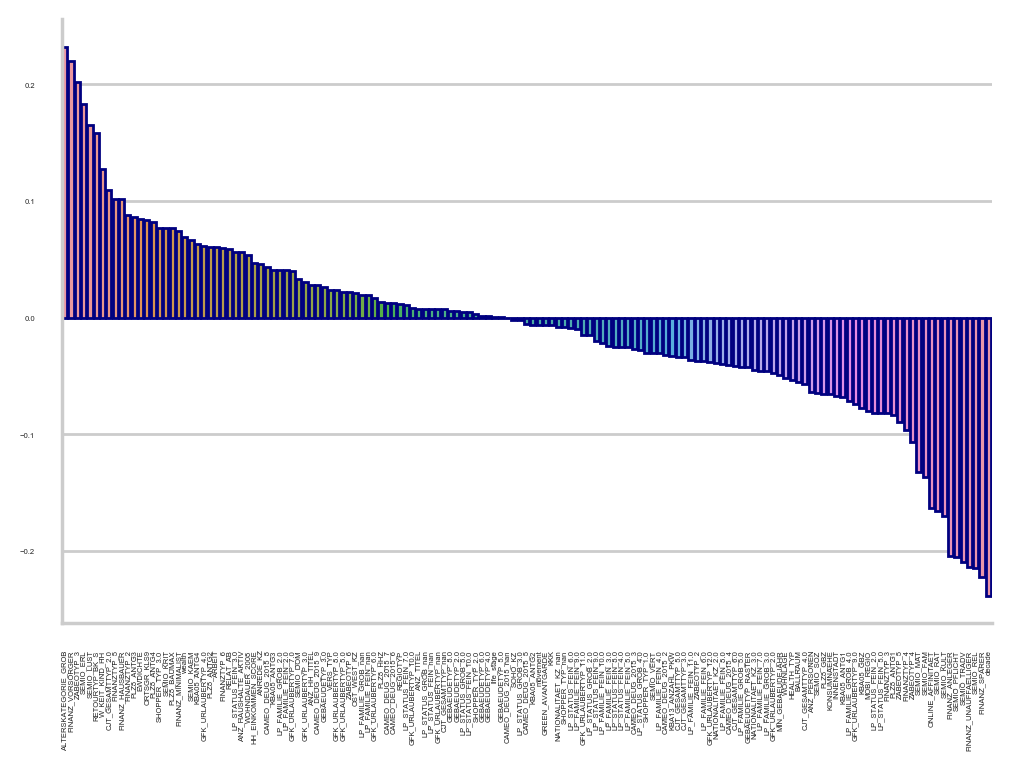

In [318]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
feature_sort(gp, pca, 1), plot_features(feature_sort(gp, pca, 1))

([(0.3302408672275322, 'SEMIO_VERT'),
  (0.26182851181873024, 'SEMIO_SOZ'),
  (0.25998507690082096, 'SEMIO_FAM'),
  (0.2508389568667618, 'SEMIO_KULT'),
  (0.1413456614524455, 'FINANZTYP_5'),
  (0.14131339846241453, 'FINANZ_MINIMALIST'),
  (0.10524824791089342, 'SEMIO_REL'),
  (0.08885119670295477, 'movement'),
  (0.08885119670295477, 'GREEN_AVANTGARDE'),
  (0.087151314939896, 'SEMIO_MAT'),
  (0.07659470898627274, 'RETOURTYP_BK_S'),
  (0.0652499339346698, 'W_KEIT_KIND_HH'),
  (0.06461538046811979, 'LP_STATUS_GROB_5.0'),
  (0.06461538046811979, 'LP_STATUS_FEIN_10.0'),
  (0.06296302230013877, 'ORTSGR_KLS9'),
  (0.06258962585576018, 'EWDICHTE'),
  (0.06038814584847906, 'SHOPPER_TYP_1.0'),
  (0.05281828401464864, 'FINANZ_VORSORGER'),
  (0.04951519761491939, 'ZABEOTYP_6'),
  (0.04904583159525753, 'LP_STATUS_FEIN_3.0'),
  (0.04487817183705597, 'PLZ8_BAUMAX'),
  (0.043944805426303614, 'PLZ8_ANTG3'),
  (0.04343747736686359, 'PLZ8_ANTG4'),
  (0.03368663479854492, 'RELAT_AB'),
  (0.03347378268298

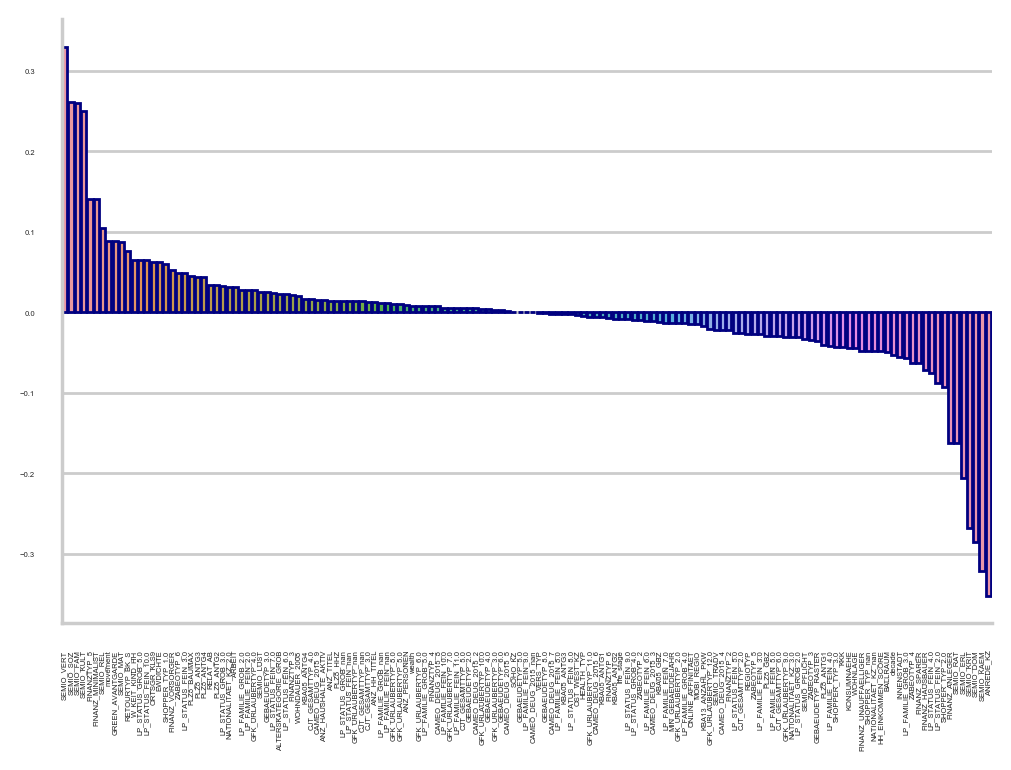

In [319]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
feature_sort(gp, pca, 2) , plot_features(feature_sort(gp, pca, 2))

### Discussion 2.3: Interpret Principal Components

I created a list and plot to show the Features together with their weights (importance) on which different components of PCA are built. It seems those features with a high weight (either positive or negative) in one component have low importance and weight in other two components meaning using the several top components of PCA does not cause a negative computational impact and they do not have contradiction one to another. There is seemingly a meaningful correlation between features. For instance wealth, decade, and movement are proportionally or inversely correlated in different components. 

Inferences made on correlations between original features of the data and the first three PCA components are as below:

 1. This latent feature is mostly related to House-hold size and wealth, Financial typology and family/community size and type. 
 2. It encompasses Age related, personality typology and behavioral characteristics of customers.
 3. It is mostly about personality typology and also gender.  


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [320]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...
    # compute the average within-cluster distances.
from sklearn.cluster import KMeans
score = []
for i in range(10,30):
    kmean_model = KMeans(i)
    model = kmean_model.fit(X_pca)
# Obtain the score for each model (take the absolute value)
    score.append(np.abs(model.score(X_pca)))       

Text(0, 0.5, 'Sum of Score Error')

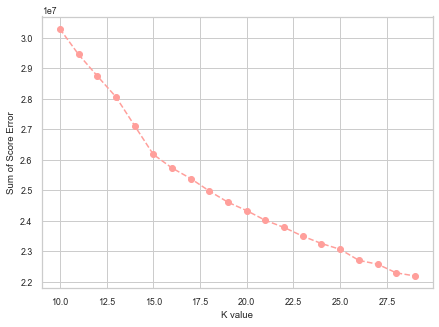

In [238]:
# save the score for different cluster with 80 PCA components
score80 = score.copy()

# Investigate the change in within-cluster distance across number of clusters. (for 80 components)
# HINT: Use matplotlib's plot function to visualize this relationship.

# Plot the score against k
sns.set(style="whitegrid",palette = 'pastel', font_scale=0.8)
plt.figure(figsize=(7,5))
plt.plot(list(range(10,30)), score80, 'r', linestyle='--', marker='o')
plt.xlabel('K value')
plt.ylabel('Sum of Score Error')

Text(0, 0.5, 'Sum of Score Error')

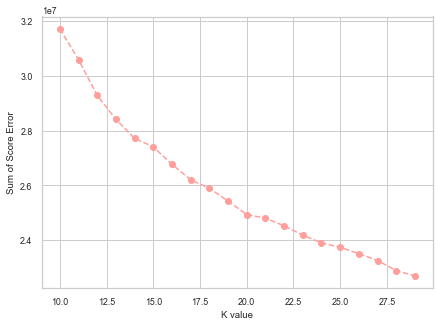

In [321]:
# Investigate the change in within-cluster distance across number of clusters. (for 20 components)
# HINT: Use matplotlib's plot function to visualize this relationship.

# Plot the score against k
sns.set(style="whitegrid",palette = 'pastel', font_scale=0.8)
plt.figure(figsize=(7,5))
plt.plot(list(range(10,30)), score, 'r', linestyle='--', marker='o')
plt.xlabel('K value')
plt.ylabel('Sum of Score Error')

In [322]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmean_model = KMeans(29)
model = kmean_model.fit(X_pca)
gp_labels = model.predict(X_pca)

### Discussion 3.1: Apply Clustering to General Population

A PCA with 20 component were eventually selected to run the clustering. Cincreasing the cluster numbers shows improvement in the score. Based on this analysis, 29 clusters were considered to re-fit the k-mean clustering model and labels were predicted. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [334]:
# Load in the customer demographics data.
# Load in the customer demographics data.
customers =  pd.read_table('Udacity_CUSTOMERS_Subset.csv', sep=';')

# Load in the feature summary file again because it has been changed during the past process
feat_info = pd.read_table('AZDIAS_Feature_Summary.csv', sep=';')

# Load in the general demographics data again because it has been changed during the past process
azdias = pd.read_table('Udacity_AZDIAS_Subset.csv', sep=';')

In [324]:
azdias.shape, customers.shape

((891221, 85), (191652, 85))

In [335]:
# There might be a miss match between customer data and population data. Let's check it up.
customer_list = customers.columns.tolist() 
population_list = azdias.columns.tolist()
print('Not in Customer but in Population:', [x for x in customer_list if x not in population_list])
print('Not in Population but in Customer:', [x for x in population_list if x not in customer_list])
print('Are columns in the both dataset the same?', customer_list==population_list)

Not in Customer but in Population: []
Not in Population but in Customer: []
Are columns in the both dataset the same? True


In [336]:
pd.DataFrame(columns=[customer_list, population_list]).transpose()

,
AGER_TYP,AGER_TYP
ALTERSKATEGORIE_GROB,ALTERSKATEGORIE_GROB
ANREDE_KZ,ANREDE_KZ
CJT_GESAMTTYP,CJT_GESAMTTYP
FINANZ_MINIMALIST,FINANZ_MINIMALIST
...,...
PLZ8_HHZ,PLZ8_HHZ
PLZ8_GBZ,PLZ8_GBZ
ARBEIT,ARBEIT
ORTSGR_KLS9,ORTSGR_KLS9


In [337]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

cu, good_subset_cu = clean_data(customers, feat_info)

In [338]:
cu.shape, gp.shape

((138930, 146), (777173, 147))

In [339]:
# There might be a miss match between customer dataset and population dataset after cleaning. Let's check it up.
customer_list = cu.columns.tolist() 
population_list = gp.columns.tolist()
print('Not in Population but in Customer:', [x for x in customer_list if x not in population_list])
print('Not in Customer but in Population:', [x for x in population_list if x not in customer_list])
print('Are columns in the both dataset the same?', customer_list==population_list)

Not in Population but in Customer: []
Not in Customer but in Population: ['GEBAEUDETYP_5.0']
Are columns in the both dataset the same? False


In [340]:
# add missing columns to customer dataset
cu[[x for x in population_list if x not in customer_list][0]] = 0
#cu[[x for x in population_list if x not in customer_list][1]] = 0

In [341]:
# check dimension
print('dimension of cu & gp:', cu.shape, gp.shape), 
print('# of null values in cu:', sum(cu.isnull().sum()))

dimension of cu & gp: (138930, 147) (777173, 147)
# of null values in cu: 0


In [342]:
# Scaling the data and run the pca
X_pca_cu = pca_fitted.transform(scaled_fitted.transform(cu))

In [343]:
# Cluster customer data
cu_labels = model.predict(X_pca_cu)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

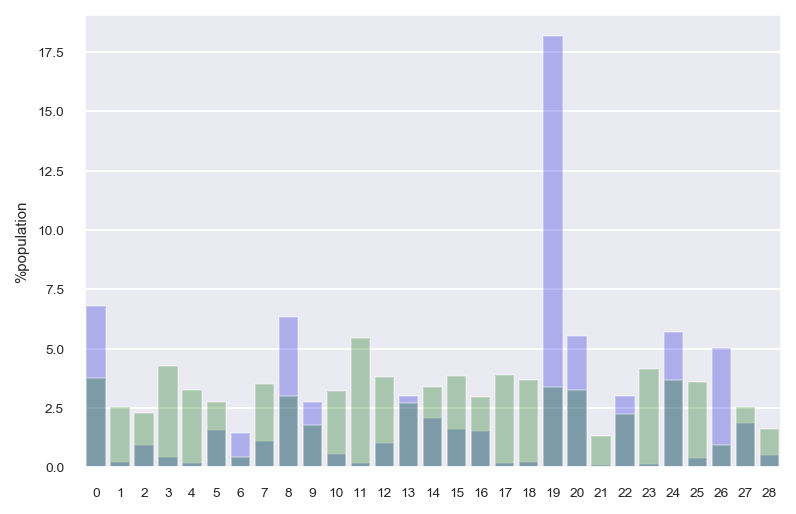

In [366]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

proportion_population = pd.DataFrame(pd.Series(gp_labels).value_counts().sort_index() * 100 / azdias.shape[0], 
                                     columns=['%population'])
proportion_customer = pd.DataFrame(pd.Series(cu_labels).value_counts().sort_index() * 100 / customers.shape[0], 
                                     columns=['%customers'])

sns.set(style="darkgrid",palette = 'pastel', font_scale=0.6)
fig,ax=plt.subplots(nrows=1,ncols=1,dpi=150 )
plt.subplots_adjust(wspace = .4 ,hspace=.5)
sns.barplot(x = proportion_customer.index, y = proportion_customer['%customers'], data=proportion_customer, color='blue', alpha=0.3)
sns.barplot(x = proportion_population.index, y = proportion_population['%population'], data=proportion_customer, color='green', alpha=0.3)

In [367]:
## need to filter dataset to answer the follwoing questions
# extract features related to personality
personality_features = feat_info[feat_info['information_level']=='person']['attribute'].tolist()

# filter clean dataset of population and customer for those persoanlity features only
personality_gp = good_subset.dropna(subset=['CAMEO_INTL_2015'])[[x for x in good_subset.columns.tolist() if x in personality_features]]
personality_cu = good_subset_cu.dropna(subset=['CAMEO_INTL_2015'])[[x for x in good_subset.columns.tolist() if x in personality_features]]

In [369]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

#Ans: category 19 is overrepresented in the customers
personality_gp['population_label'] = gp_labels
personality_cu['customer_label'] = cu_labels

compare = pd.concat([personality_gp[personality_gp['population_label']==19].mode().transpose(), 
          personality_cu[personality_cu['customer_label']==19].mode().transpose()], axis=1)
compare.columns = ['Population', 'Customer']

In [370]:
compare

,Population,Customer
ALTERSKATEGORIE_GROB,4.0,4.0
ANREDE_KZ,1.0,1.0
CJT_GESAMTTYP,2.0,2.0
FINANZ_MINIMALIST,5.0,5.0
FINANZ_SPARER,1.0,1.0
FINANZ_VORSORGER,5.0,5.0
FINANZ_ANLEGER,1.0,1.0
FINANZ_UNAUFFAELLIGER,2.0,1.0
FINANZ_HAUSBAUER,2.0,2.0
FINANZTYP,5.0,5.0


In [371]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
#Ans: category 11 is underrepresented in the customers 

compare = pd.concat([personality_gp[personality_gp['population_label']==11].mode().transpose(), 
          personality_cu[personality_cu['customer_label']==11].mode().transpose()], axis=1)
compare.columns = ['Population', 'Customer']
compare

,Population,Customer
ALTERSKATEGORIE_GROB,1.0,1.0
ANREDE_KZ,1.0,1.0
CJT_GESAMTTYP,4.0,4.0
FINANZ_MINIMALIST,2.0,2.0
FINANZ_SPARER,5.0,5.0
FINANZ_VORSORGER,1.0,2.0
FINANZ_ANLEGER,5.0,2.0
FINANZ_UNAUFFAELLIGER,4.0,5.0
FINANZ_HAUSBAUER,3.0,3.0
FINANZTYP,1.0,1.0


In [381]:
# Further analysis through inverse transform.
# inverse_transform() method of the PCA and StandardScaler objects transform centroids back to the 
# original data space and interpret the retrieved values directly. 
# With StandardScaler, strongly negative values suggest lower values on the original scale and positive values suggest higher values on the original scale.

pd.DataFrame(scaled_fitted.inverse_transform(pca.inverse_transform(model.cluster_centers_)), columns=cu.columns)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEUG_2015_nan,decade,movement,wealth,life_stage,GEBAEUDETYP_5.0
0,3.409486,1.037761,3.562905,1.433474,4.675805,0.881739,1.870548,3.758217,0.258351,1.896181,...,0.120946,0.215591,0.135869,0.236640,0.084800,0.0,60.434601,1.258351,3.649535,3.010049
1,1.973153,1.331751,3.783050,3.563942,2.267856,3.680734,3.722854,1.392985,-0.005874,2.312653,...,0.109278,0.094603,0.073951,0.010495,0.015523,0.0,85.173822,0.994126,2.244693,3.048943
2,2.600542,1.978963,3.846712,2.744210,3.115031,3.120203,2.998117,1.707292,0.995564,2.276723,...,0.058408,0.036127,0.033662,0.026274,0.017556,0.0,78.651307,1.995564,1.831668,3.398235
3,3.014875,1.065437,3.247796,2.325756,3.958342,2.282926,1.758483,3.292925,0.037315,2.586574,...,0.030959,0.168463,0.136249,0.324383,0.224037,0.0,69.105533,1.037315,4.220691,2.308872
4,1.632961,2.005629,1.844479,4.092468,2.225488,4.611345,3.984663,3.406588,0.196753,2.322478,...,0.087499,0.159256,0.064397,0.013892,-0.024790,0.0,87.263334,1.196753,2.245458,3.563954
5,3.678411,1.943742,2.327665,1.864309,4.227019,2.009841,1.538254,4.630348,0.037353,2.061205,...,0.060159,0.064284,0.129282,0.277493,0.407625,0.0,62.873779,1.037353,4.407354,2.439304
6,3.046934,1.453203,3.301762,2.467031,3.687001,2.476042,2.552669,2.901155,0.296617,2.300351,...,0.121660,0.090638,0.183406,0.135333,0.150496,0.0,72.409312,1.296617,3.364253,2.458511
7,3.024060,1.314679,4.403349,2.111420,3.705112,2.601759,2.109687,1.728474,-0.021645,2.673372,...,0.078795,0.116641,0.054646,0.050642,-0.009548,0.0,70.748809,0.978355,2.253776,3.407206
8,3.775607,1.928393,4.412810,1.182978,4.616616,1.700664,1.864692,2.514202,0.980773,1.912630,...,0.045821,0.075074,0.052369,0.024163,0.040051,0.0,60.385010,1.980773,2.051512,3.589382
9,3.214080,1.526016,3.738270,1.645011,4.301954,2.037568,1.651976,3.360550,0.181086,1.799059,...,-0.029875,0.253643,-0.058894,0.215726,0.047458,0.0,60.832387,1.181086,2.906405,3.981270


### Discussion 3.3: Compare Customer Data to Demographics Data

Customers of the company belong to almost all clusters in the whole population but pridominantly to clusters 19, 0, 8, 26 and 20. There are a lot of similarities and few unsimilarity in people charactristics among overrepresented cluster (cluster 19) in the company's customer and that of population. Cluster 19 represents people of more than 60 years old, male, traditional buyers, with good financial ability, mainly from financial type of investor, with health typology of critical reserved, with German nationality, Minimal-Returner, who cunsume mostly green products.  

Category 11 is the underrepresented category in the customer dataset. There are many similarities of personality character among people of this cluster in both population and customers. Interestingly, this cluster represents the people who are just the opposite of the people in the overrepresented cluster in term of personality, charactristics and shopping behavior. And it makes a lot of sense intutively. This is the cluster of people who are less than 30 years old, male, advertisinginterested Online-shopper, having low financial interest, Without vacation habit, not a member of green avantgarde, mainly single, from digital media kids category, with shopper typology of Shopping-stressed and price driven.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

## End of Document